## Análise da cesta de mercado Instacart

A análise a seguir foi conduzida utilizando dados da Instacart disponibilizados no site www.kaggle.com

O Instacart é um aplicativo de compras online, no qual os usuários selecionam os produtos desejados na plataforma, 
sendo a entrega realizada na loja mais próxima à sua localização.
O problema aborda a previsão dos produtos que um consumidor do Instacart irá adquirir novamente. Nesse contexto, buscarei prever quais itens comprados estarão presentes no próximo pedido de um usuário ou cliente.

**Questões que buscaremos abordar por meio da análise:**
* Quando as pessoas realizam seus pedidos?
* Quantos pedidos existem por cliente?
* Com que frequência os clientes fazem pedidos novamente?
* Quais produtos são frequentemente pedidos?
* Quais são os departamentos mais populares?

### Carregando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

%matplotlib inline

### Carregando conjuntos de dados 

In [2]:
corredores = pd.read_csv('aisles.csv')
departamentos = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
pedidos = pd.read_csv('orders.csv')
produtos = pd.read_csv('products.csv')

### Análise exploratória de dados

In [3]:
# Tamanho do conjunto de dados de pedidos
pedidos.shape

(3421083, 7)

In [4]:
# Visualização dos pedidos
pedidos.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


* **order_id:** Identificador do pedido
* **user_id:** Identificador do cliente
* **eval_set:** Qual conjunto de avaliação (anterior, treinamento ou teste) cada linha pertence 
* **order_number:** O número de sequência do pedido para este usuário (1 = primeiro, n = enésimo)
* **order_dow:** Dia da semana em que o pedido foi feito
* **order_hour_of_day:** A hora do dia em que o pedido foi realizado
* **days_since_prior_order:** Dias desde o último pedido, limitado a 30 

* Como pudemos ver, o arquivo orders.csv abrange todas as informações relacionadas ao ID do pedido fornecido, incluindo detalhes sobre a maneira como o usuário realizou a compra, a data da compra, os dias decorridos desde o pedido anterior, entre outros aspectos.

In [5]:
# Informações dos pedidos
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [6]:
# Explorando a porcentagem de valores ausentes para cada recurso
print('Número de valores ausentes: ', pedidos.isnull().values.sum())
print('Porcentagem de valores ausentes por recurso: ') 
pedidos.isnull().sum() * 100 / len(pedidos)

Número de valores ausentes:  206209
Porcentagem de valores ausentes por recurso: 


order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.027594
dtype: float64

* Em 6% dos pedidos, há valores ausentes para a variável "days_since_prior_order", indicando que essa parcela representa os primeiros pedidos realizados pelos usuários neste conjunto de dados.

### Conjunto de dados de pedidos de produtos

In [7]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


* **order_id**: Identificador do pedido
* **product_id**: Identificador do produto
* **add_to_cart_order**: Ordem em que cada produto foi adicionado ao carrinho
* **reordered**:  Se este produto foi previamente solicitado por este usuário, atribuímos o valor 1; caso contrário, atribuímos o valor 0.

In [8]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


* As colunas presentes nos arquivos order_products_train e order_products_prior são idênticas. A distinção entre esses conjuntos de dados reside no contexto de uso. Neste conjunto de dados, são fornecidos dados relativos a 4 a 100 pedidos de um cliente, com o objetivo de prever os produtos que serão solicitados novamente.


* O último pedido do usuário foi isolado e dividido em conjuntos de treinamento e teste. Todas as informações referentes aos pedidos anteriores do cliente podem ser encontradas no arquivo order_products_prior



* Quanto ao arquivo order_products.csv, ele contém informações mais detalhadas sobre os produtos comprados em um pedido específico, juntamente com o status do novo pedido.

### Contagem de linhas nos Conjuntos de Dados: Uma análise detalhada

In [9]:
# Fazendo a importação da biblioteca para anular os avisos padrões
import warnings

warnings.filterwarnings('ignore')

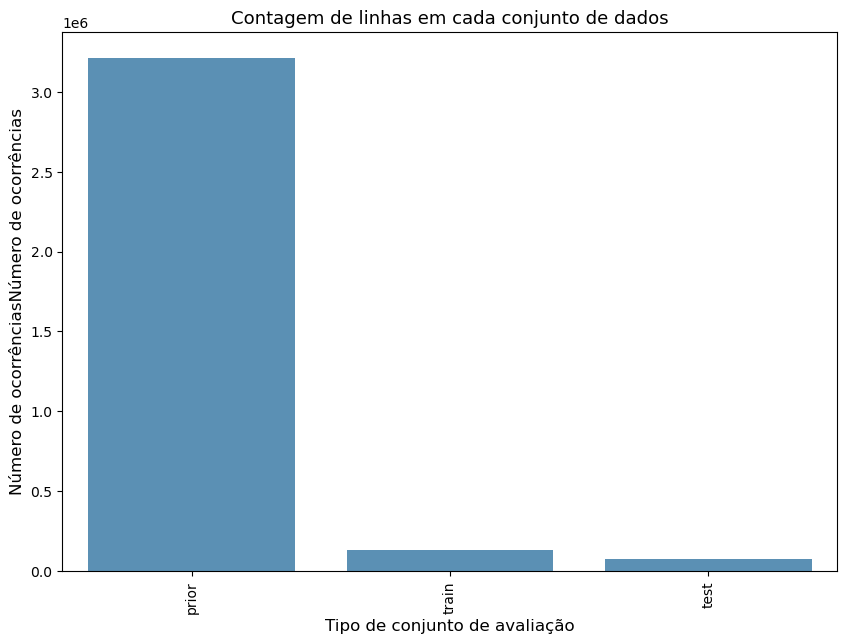

In [99]:
count_series = pedidos.eval_set.value_counts()

plt.figure(figsize=(10,7))
sns.barplot(count_series.index, count_series.values, alpha=0.8, color=color[0])
plt.ylabel('Número de ocorrênciasNúmero de ocorrências', fontsize=12)
plt.xlabel('Tipo de conjunto de avaliação', fontsize=12)
plt.title('Contagem de linhas em cada conjunto de dados', fontsize=13)
plt.xticks(rotation='vertical')
plt.show()

In [126]:
# Contagem de usuários únicos em diferentes conjuntos de dados
count_series = pedidos.groupby("eval_set")["user_id"].nunique()
count_series

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

* O total de clientes é de 206.209. Destes, as informações sobre a última compra de 131.209 clientes estão designadas como o conjunto de treinamento, e nossa tarefa é prever os padrões de compra para os restantes 75.000 clientes. 


### Validação da variação de pedidos por cliente: De 4 a 100

In [12]:
# Quantos pedidos existem por cliente?
pedidos.groupby('user_id')['order_id'].nunique().describe()

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_id, dtype: float64

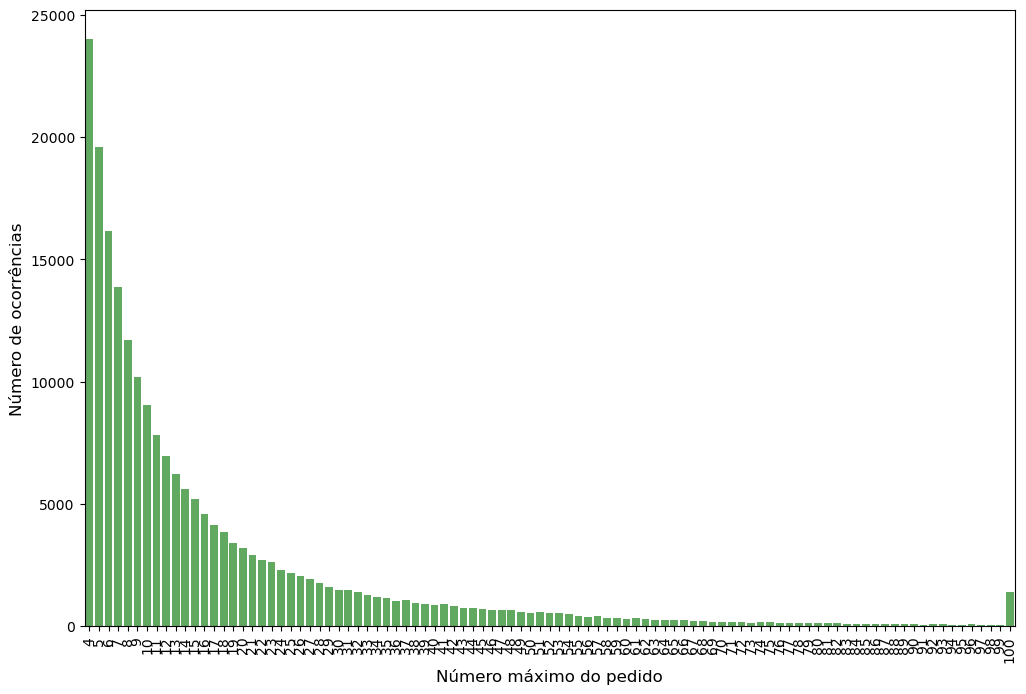

In [101]:
count_series = pedidos.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
count_series = count_series.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(count_series.index, count_series.values, alpha=0.8, color=color[2])
plt.ylabel('Número de ocorrências', fontsize=12)
plt.xlabel('Número máximo do pedido', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

* Analisando o gráfico acima, não existem registros de pedidos com uma quantidade inferior a 4, e o número máximo de pedidos por cliente é estabelecido em 100, conforme indicado na página de dados. 

### Variação dos padrões de compra ao longo da semana

* **Quando as pessoas fazem seus pedidos?**

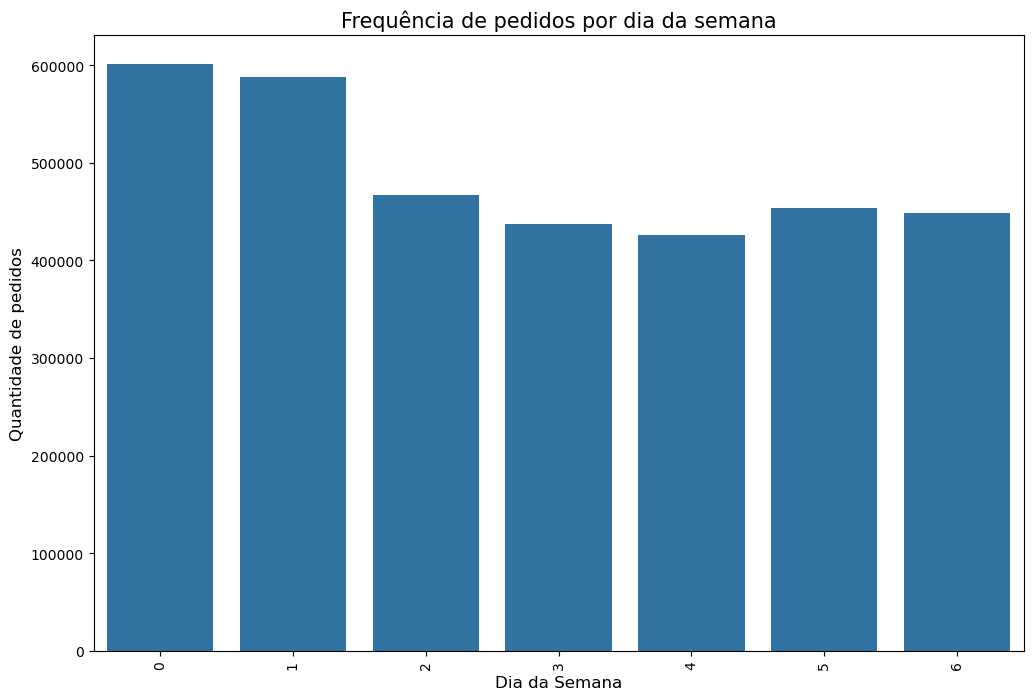

In [14]:
# Número de pedidos por dia da semana
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=pedidos, color=color[0])
plt.ylabel('Quantidade de pedidos', fontsize=12)
plt.xlabel('Dia da Semana', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequência de pedidos por dia da semana", fontsize=15)
plt.show()

* O gráfico sugere que 0 e 1 correspondem a sábado e domingo, períodos em que as solicitações de pedidos atingem picos e vales, notadamente durante a quarta-feira.

### Explorando a distribuição em relação à hora do dia.

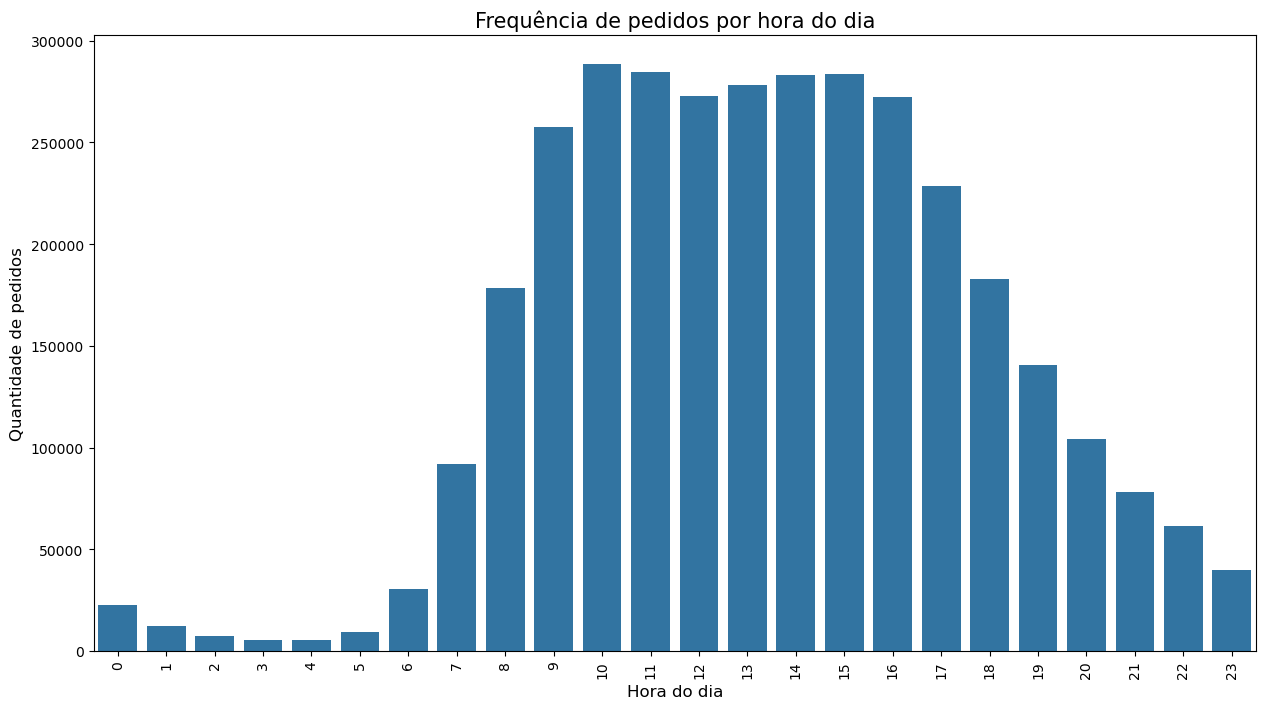

In [49]:
# A que horas ocorre o maior número de pedidos
plt.figure(figsize=(15,8))
sns.countplot(x="order_hour_of_day", data=pedidos, color=color[0])
plt.ylabel('Quantidade de pedidos', fontsize=12)
plt.xlabel('Hora do dia', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequência de pedidos por hora do dia", fontsize=15)
plt.show()

* Conforme o gráfico acima, a maioria dos pedidos ocorre durante o dia.

### Explorando a distribuição com base na combinação de dia da semana e hora do dia

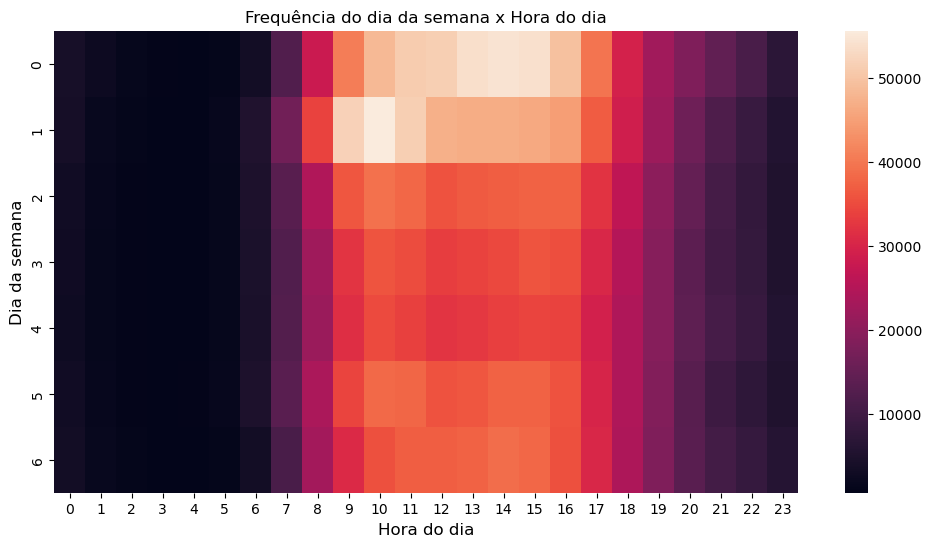

In [16]:
grouped_df = pedidos.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequência do dia da semana x Hora do dia")
plt.ylabel('Dia da semana', fontsize = 12)
plt.xlabel('Hora do dia', fontsize = 12)
plt.show()

* Analisando o gráfico acima, as noites de sábado e as manhãs de domingo representam o período de pico para pedidos.

### Analisando o intervalo de tempo entre os pedidos

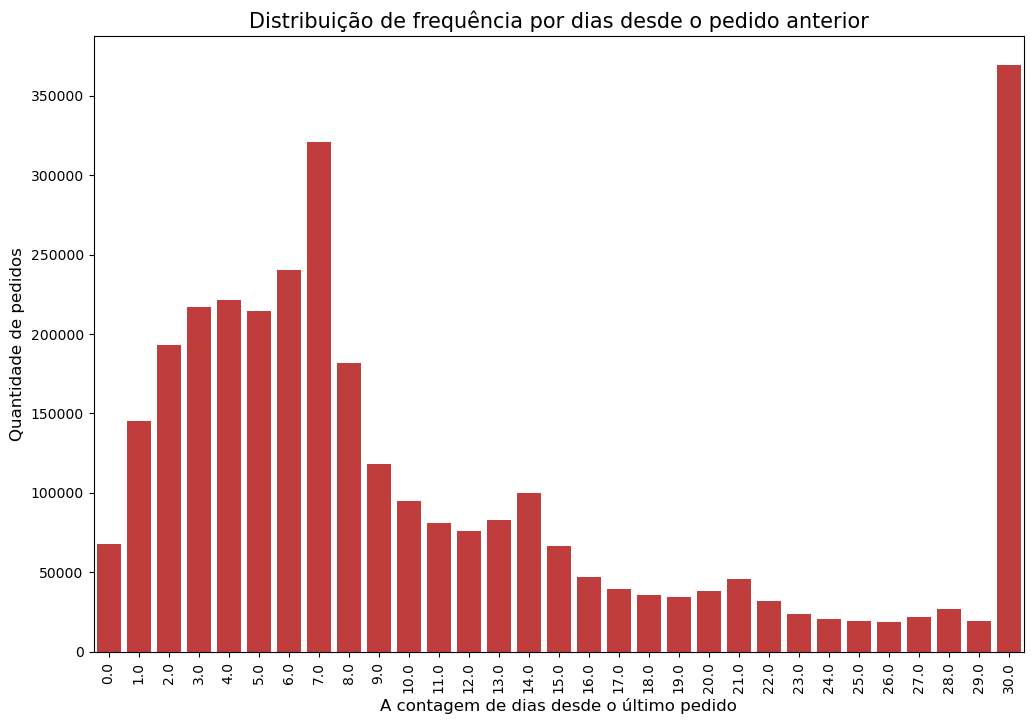

In [17]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=pedidos, color=color[3])
plt.ylabel('Quantidade de pedidos', fontsize=12)
plt.xlabel('A contagem de dias desde o último pedido', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribuição de frequência por dias desde o pedido anterior", fontsize=15)
plt.show()

* Analisando o gráfico acima, os clientes efetuam pedidos com frequência semanal, evidenciado pelo pico em 7 dias, ou mensal, destacado pelo pico em 30 dias. Além disso, observamos picos menores nos intervalos de 14, 21 e 28 dias, indicando padrões semanais adicionais. 


### Análise da porcentagem de novos pedidos nos conjuntos anterior e de treinamento

In [70]:
# Porcentagem de novos pedidos no conjunto anterior
order_products_prior.reordered.sum() / order_products_prior.shape[0] 

0.5896974667922161

In [71]:
# Porcentagem de novos pedidos no conjunto de treinamentos
order_products_train.reordered.sum() / order_products_train.shape[0] 

0.5985944127509629

* A proporção de itens reordenados é maior, quase 60%, o que indica o hábito de pedir os mesmos itens.

**Após observarmos que cerca de 59% dos produtos são reordenados, é relevante investigar situações em que nenhum dos produtos é reordenado. Vamos examinar isso agora.**

In [20]:
grouped_df = order_products_prior.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [21]:
grouped_df = order_products_train.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

* Aproximadamente 12% dos pedidos no conjunto anterior não apresentam itens reordenados, em contraste com a taxa de 6,5% no conjunto de treinamento.

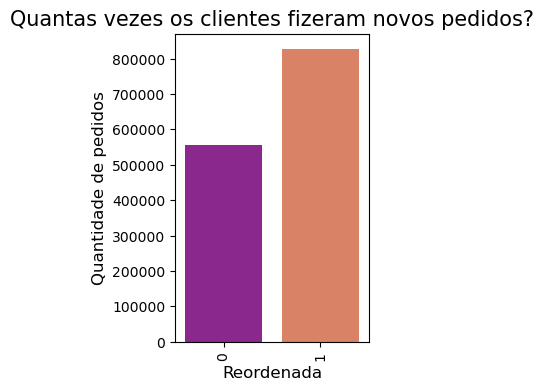

In [121]:
# Quantas vezes os clientes fizeram novos pedidos?
plt.figure(figsize=(2.5,4))
sns.countplot(x='reordered', data= order_products_train, palette='plasma')
plt.ylabel('Quantidade de pedidos', fontsize=12)
plt.xlabel('Reordenada', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Quantas vezes os clientes fizeram novos pedidos?", fontsize=15)
plt.show()

### Análise da quantidade de produtos comprados em cada pedido

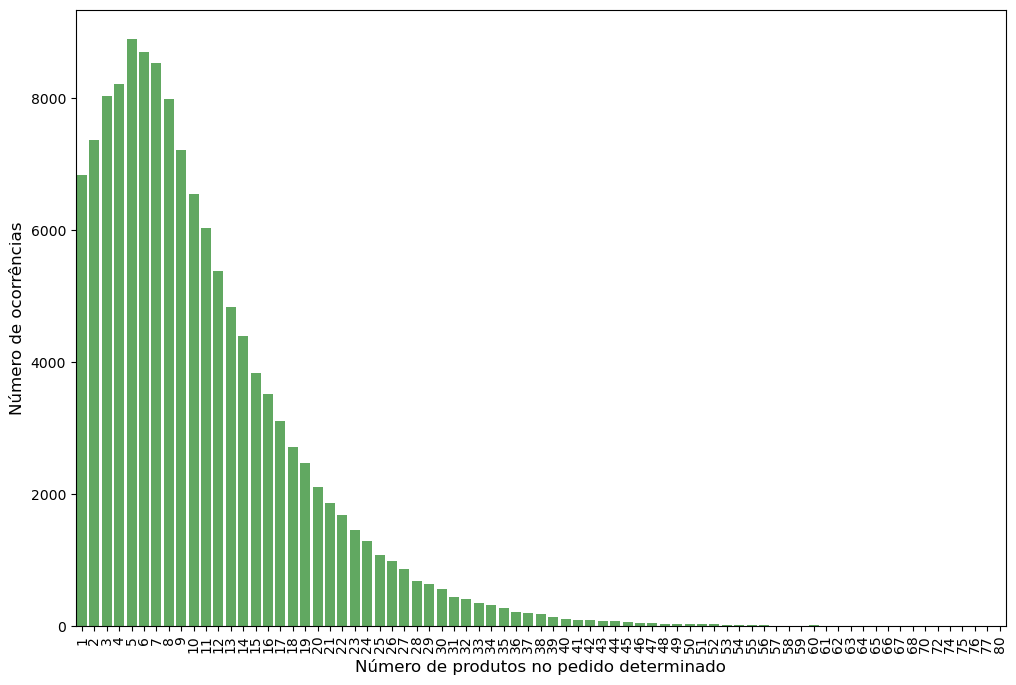

In [22]:
grouped_df = order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
count_series = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(count_series.index, count_series.values, alpha=0.8, color=color[2])
plt.ylabel('Número de ocorrências', fontsize=12)
plt.xlabel('Número de produtos no pedido determinado', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

* Analisando o gráfico acima, uma distribuição com cauda direita, onde o valor máximo é 5.

#### Antes de nos aprofundarmos nos detalhes do produto, vamos examinar os outros três arquivos.

### Conjunto de dados de Produtos

In [23]:
# Tamanho do conjunto de dados  
produtos.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


* **product_id:** Identificador do produto 
* **product_name:** Nome do produto
* **aisle_id:** Identificador do corredor
* **department_id:** Identificador do departamento

In [24]:
# Inforamções 
produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [25]:
# Explorando a porcentagem de valores ausentes para cada recurso
print('Número de valores ausentes: ', produtos.isnull().values.sum())
print('Porcentagem de valores ausentes por recurso: ') 
produtos.isnull().sum() * 100 / len(produtos)

Número de valores ausentes:  0
Porcentagem de valores ausentes por recurso: 


product_id       0.0
product_name     0.0
aisle_id         0.0
department_id    0.0
dtype: float64

### Conjunto de dados de corredores

In [26]:
# Tamanho do conjunto de dados 
corredores.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [27]:
corredores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [28]:
# Explorando a porcentagem de valores ausentes para cada recurso
print('Número de valores ausentes: ', corredores.isnull().values.sum())
print('Porcentagem de valores ausentes por recurso: ') 
corredores.isnull().sum() * 100 / len(corredores)

Número de valores ausentes:  0
Porcentagem de valores ausentes por recurso: 


aisle_id    0.0
aisle       0.0
dtype: float64

### Conjunto de dados do Departamentos

In [29]:
# Tamanho do conjunto de dados
departamentos.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [30]:
# Informações
departamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [31]:
# Explorando a porcentagem de valores ausentes para cada recurso
print('Número de valores ausentes: ', departamentos.isnull().values.sum())
print('Porcentagem de valores ausentes por recurso: ') 
departamentos.isnull().sum() * 100 / len(departamentos)

Número de valores ausentes:  0
Porcentagem de valores ausentes por recurso: 


department_id    0.0
department       0.0
dtype: float64

### Mesclando detalhes do produto com os detalhes do pedido anterior

In [32]:
order_products_prior = pd.merge(order_products_prior, produtos, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, corredores, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departamentos, on='department_id', how='left')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [33]:
# Lista dos produtos
count_series = order_products_prior['product_name'].value_counts().reset_index().head(20)
count_series.columns = ['product_name', 'frequency_count']
count_series

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


* **product_name:** Nome do produto
* **frequency_count:** Frequência da quantidade de pedidos

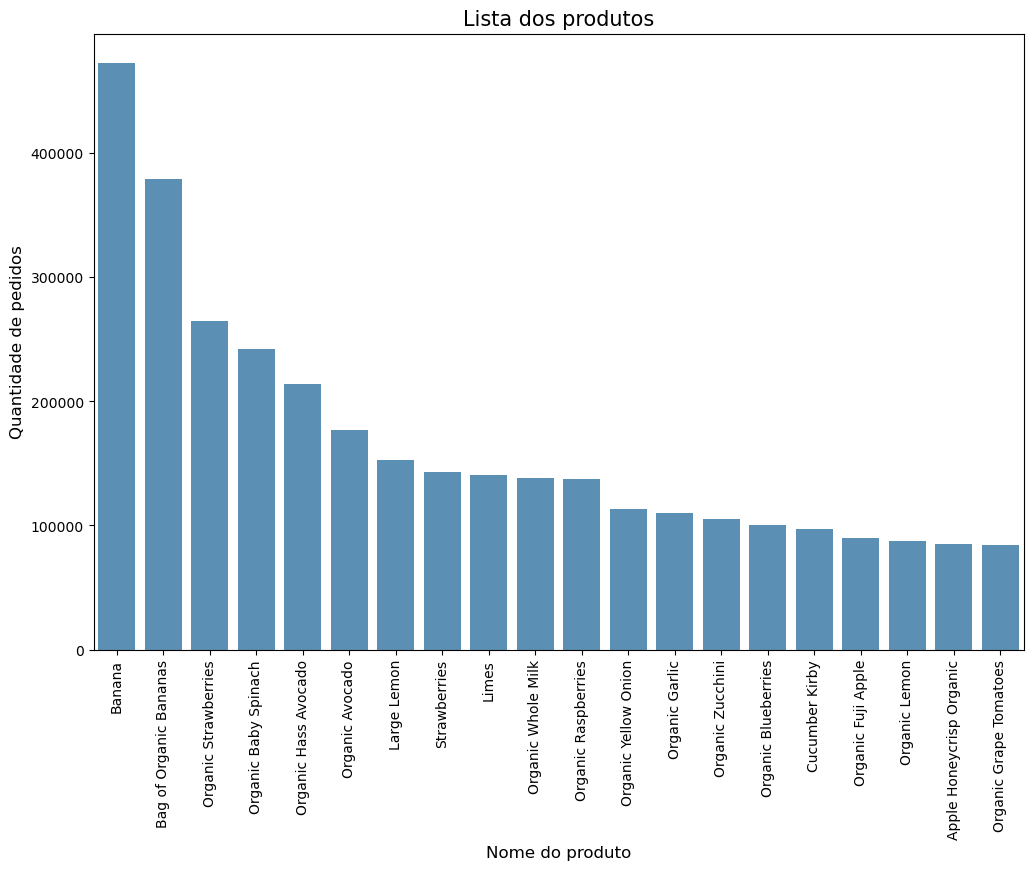

In [116]:
count_series = order_products_prior['product_name'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(count_series.index, count_series.values, alpha=0.8, color=color[0])
plt.ylabel('Quantidade de pedidos', fontsize=12)
plt.xlabel('Nome do produto', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Lista dos produtos", fontsize=15)
plt.show()

* Analisando o gráfico acima, os 12 principais produtos adicionados ao carrinho consideram a Banana como o número um. A maioria dos produtos são frutas, principalmente orgânicas.

### Explorando os corredores relevantes

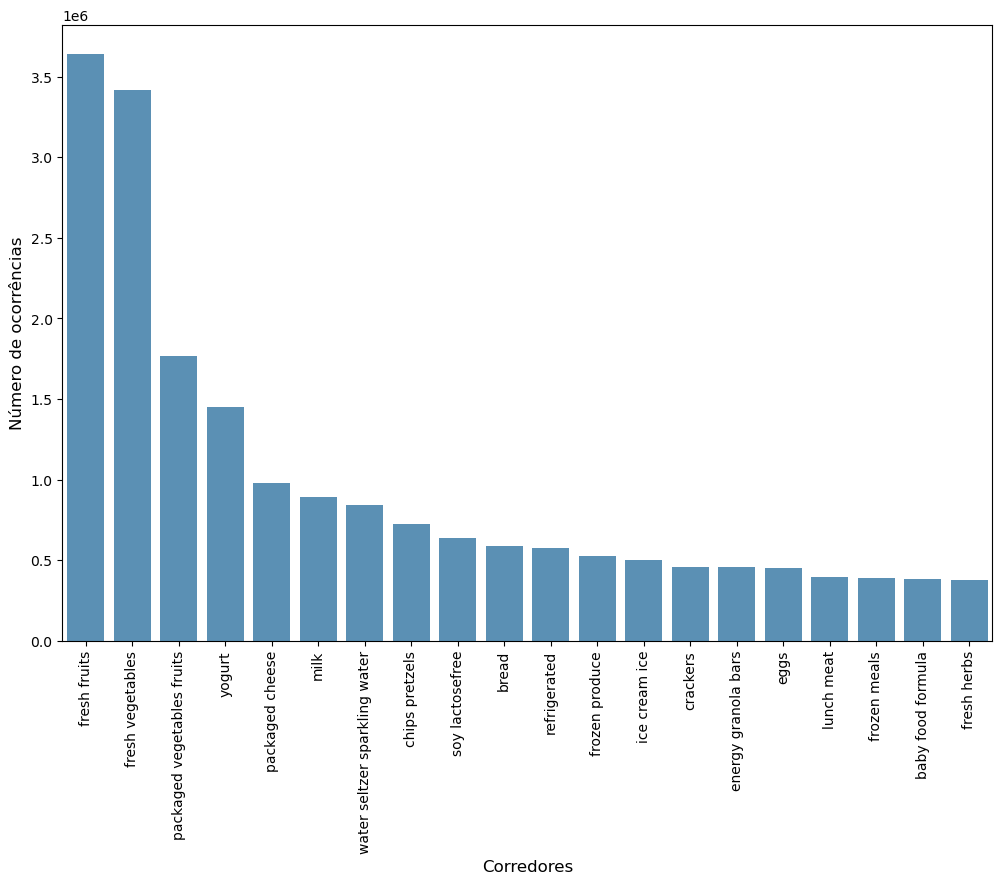

In [36]:
count_series = order_products_prior['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(count_series.index, count_series.values, alpha=0.8, color=color[0])
plt.ylabel('Número de ocorrências', fontsize=12)
plt.xlabel('Corredores', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

* Analisando o gráfico acima, os dois corredores superiores incluem frutas frescas e vegetais frescos.

### Analisando a distribuição por Departamento

In [73]:
order_products_prior['department'].value_counts()

produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
household           738666
breakfast           709569
meat seafood        708931
personal care       447123
babies              423802
international       269253
alcohol             153696
pets                 97724
missing              69145
other                36291
bulk                 34573
Name: department, dtype: int64

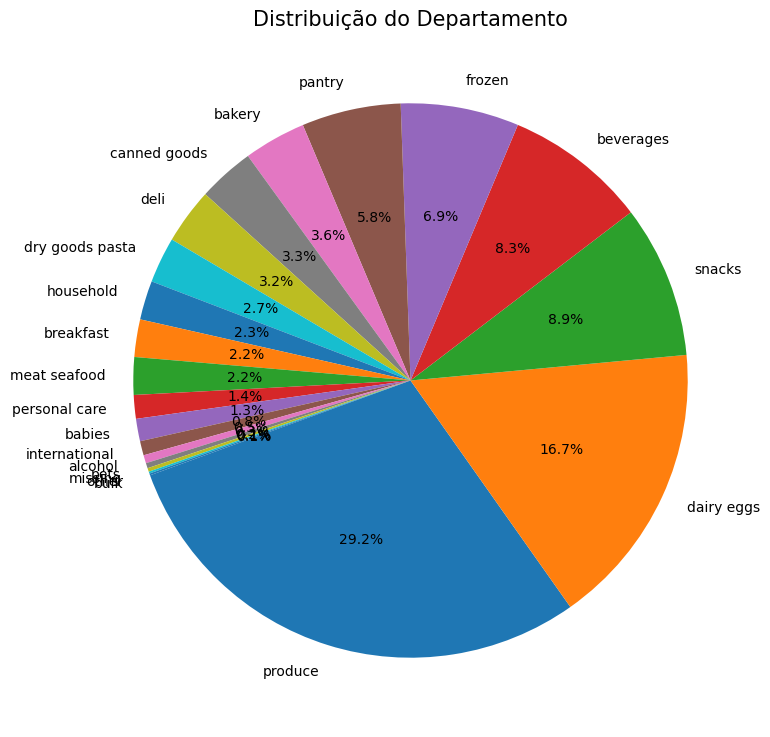

In [47]:
plt.figure(figsize=(9,9))
temp_series = order_products_prior['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Distribuição do Departamento", fontsize=15)
plt.show()

* Analisando o gráfico acima, o departamento de produção é o maior, seguido pelo departamento de ovos lácteos, e em terceiro lugar estão os lanches.

### Analisando a porcentagem de reordenação por Departamento

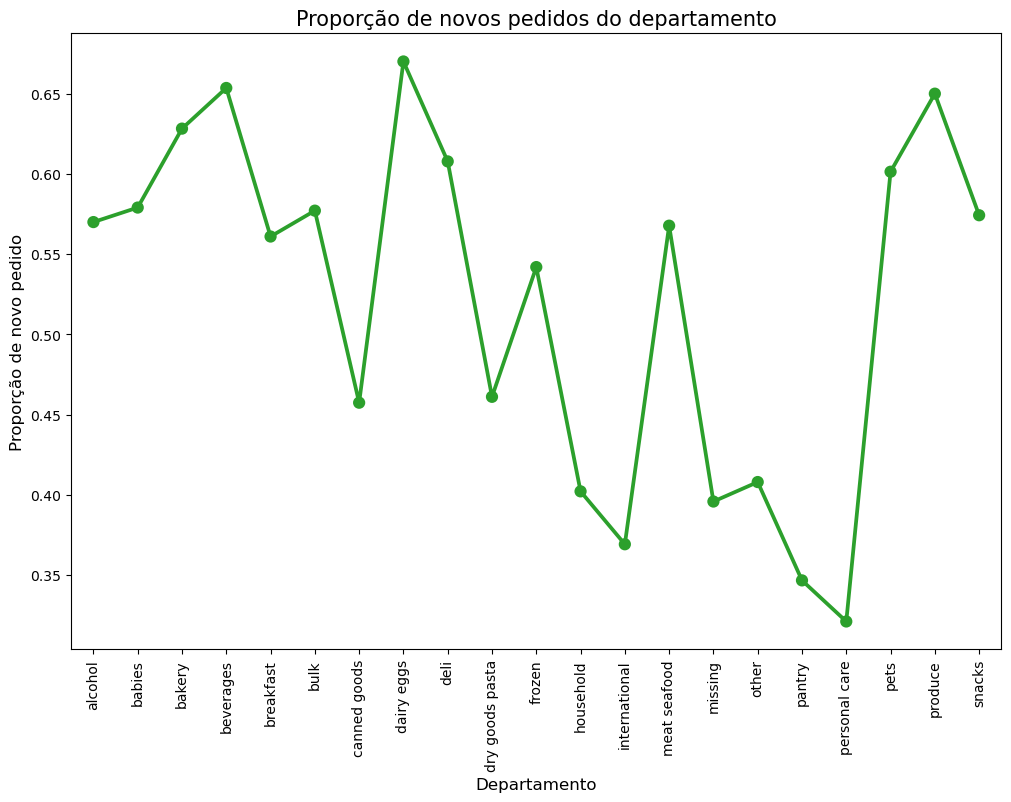

In [48]:
# Taxa de reabastecimento do departamento
grouped_df = order_products_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Proporção de novo pedido', fontsize=12)
plt.xlabel('Departamento', fontsize=12)
plt.title("Proporção de novos pedidos do departamento", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

* Analisando o gráfico acima, os produtos de cuidados pessoais apresentam a menor taxa de reposição, enquanto os produtos de ovos lácteos têm a mais alta taxa de reposição.

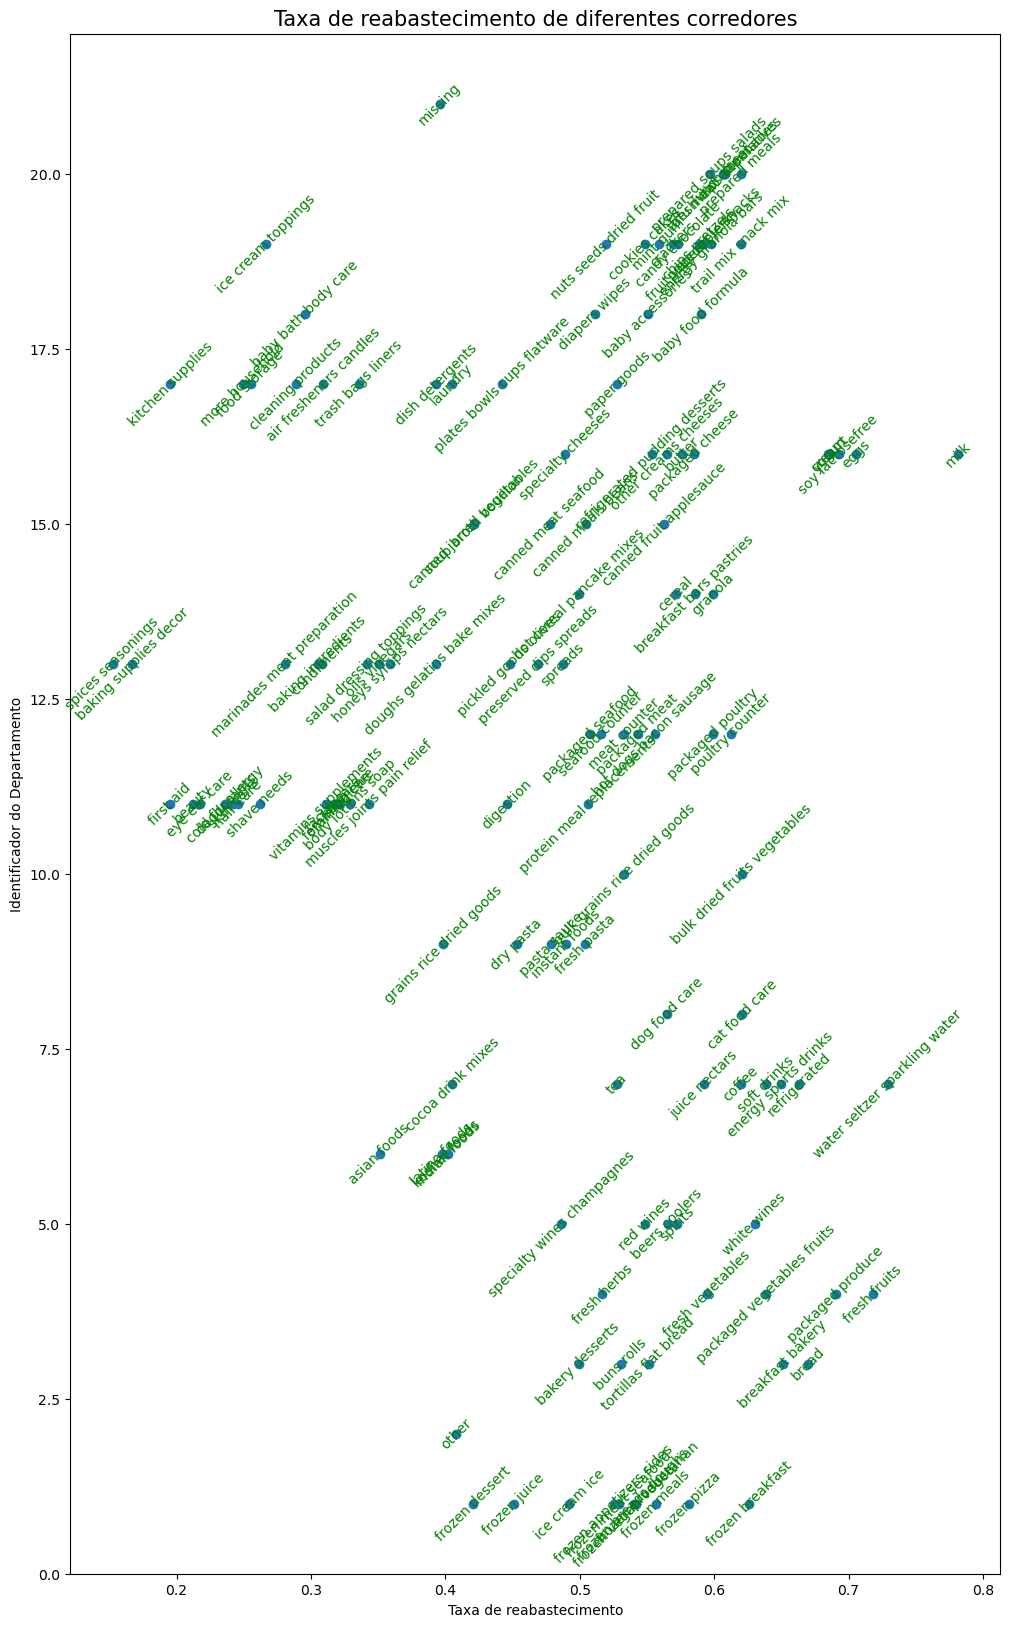

In [50]:
# Corredores - Proporção de novos pedidos
grouped_df = order_products_prior.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Taxa de reabastecimento')
plt.ylabel('Identificador do Departamento')
plt.title("Taxa de reabastecimento de diferentes corredores", fontsize=15)
plt.show()

### Explorando a relação entre a ordem de adição do produto ao carrinho e a taxa de novos pedidos

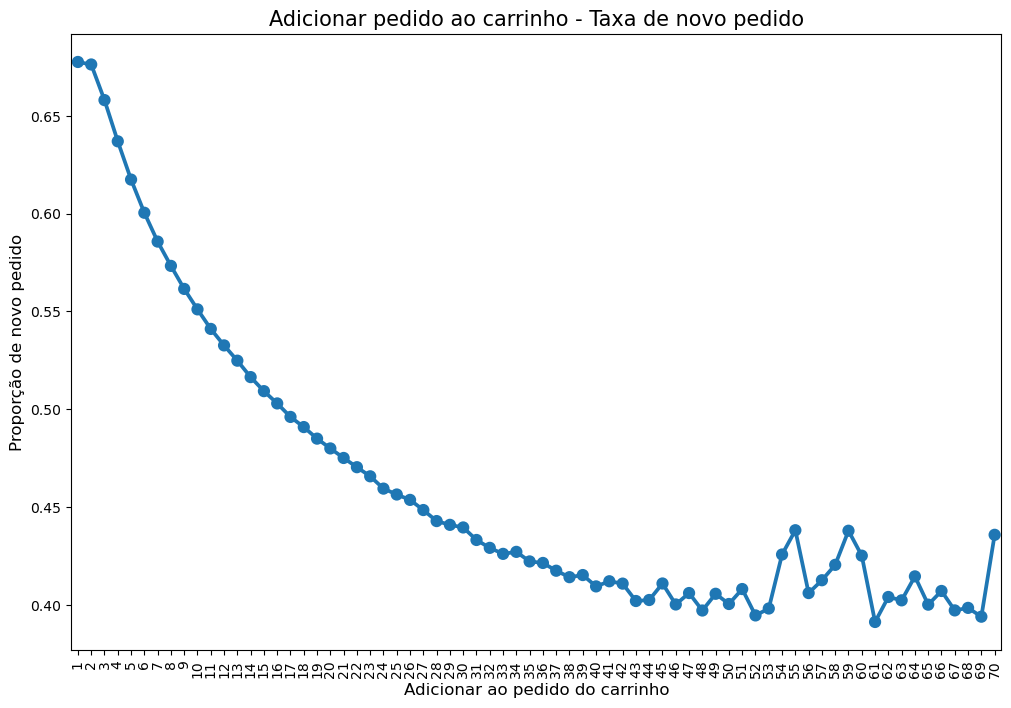

In [56]:
# Adicionar ao carrinho - Proporção de novos pedidos
order_products_prior["add_to_cart_order_mod"] = order_products_prior["add_to_cart_order"].copy()
order_products_prior["add_to_cart_order_mod"].loc[order_products_prior["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[0])
plt.ylabel('Proporção de novo pedido', fontsize=12)
plt.xlabel('Adicionar ao pedido do carrinho', fontsize=12)
plt.title("Adicionar pedido ao carrinho - Taxa de novo pedido", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

* Analisando o gráfico acima, os produtos inicialmente adicionados ao carrinho apresentam uma probabilidade maior de serem requisitados novamente em comparação com os adicionados posteriormente. Isso ocorre porque tendemos a incluir primeiramente os produtos que costumamos comprar com frequência antes de explorar novos itens disponíveis.

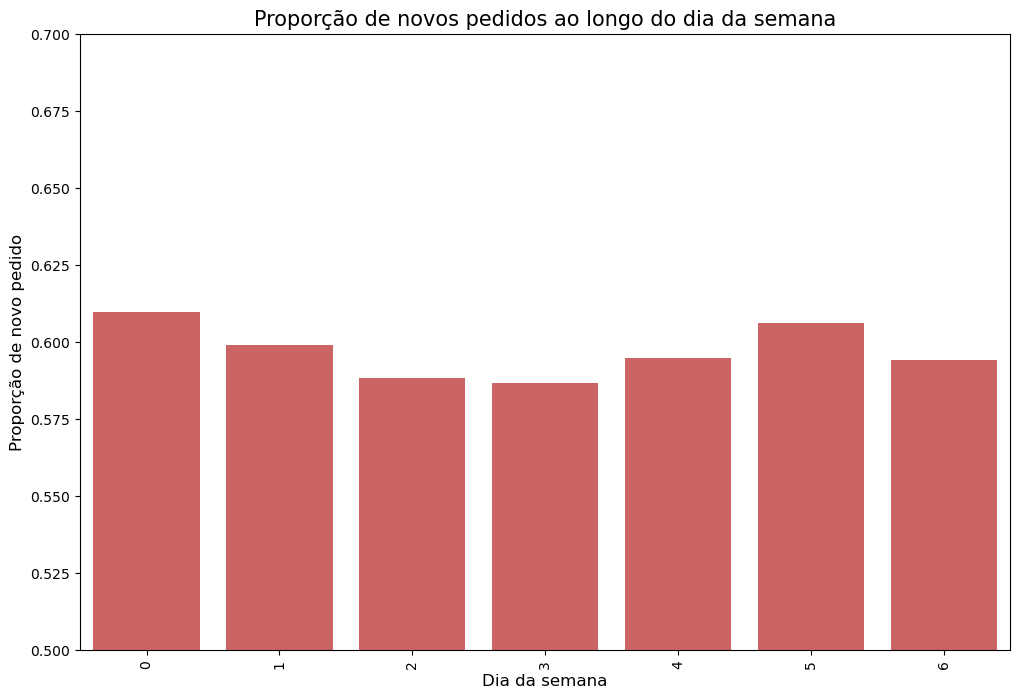

In [65]:
# Proporção de reordenação por variáveis baseadas no tempo
order_products_train = pd.merge(order_products_train, pedidos, on='order_id', how='left')
grouped_df = order_products_train.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Proporção de novo pedido', fontsize=12)
plt.xlabel('Dia da semana', fontsize=12)
plt.title("Proporção de novos pedidos ao longo do dia da semana", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

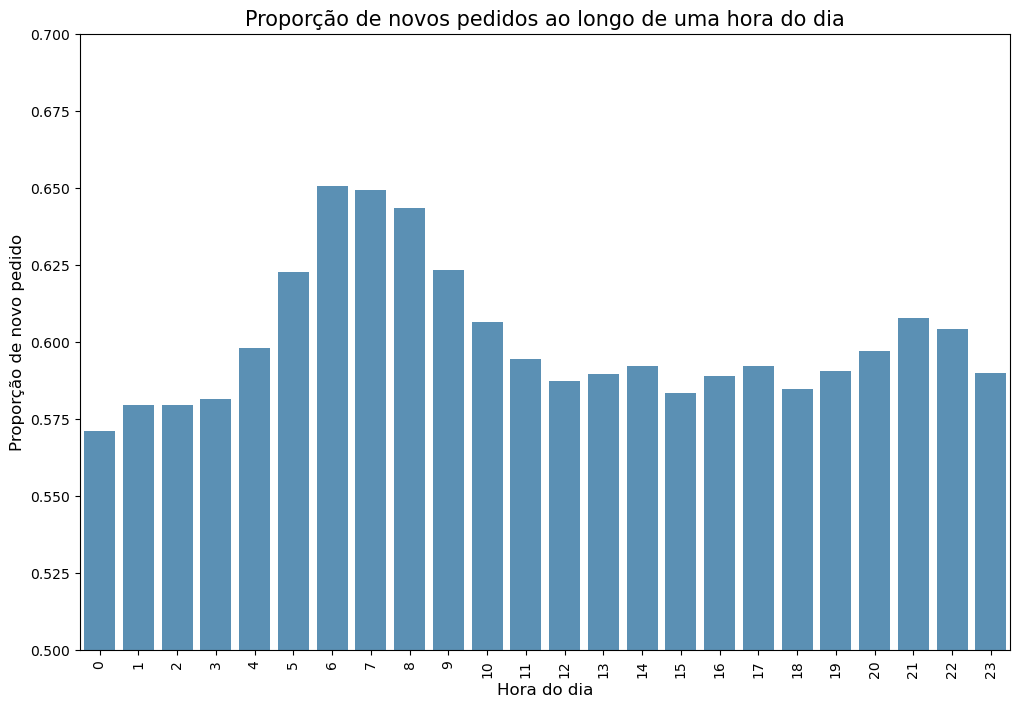

In [66]:
grouped_df = order_products_train.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[0])
plt.ylabel('Proporção de novo pedido', fontsize=12)
plt.xlabel('Hora do dia', fontsize=12)
plt.title("Proporção de novos pedidos ao longo de uma hora do dia", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

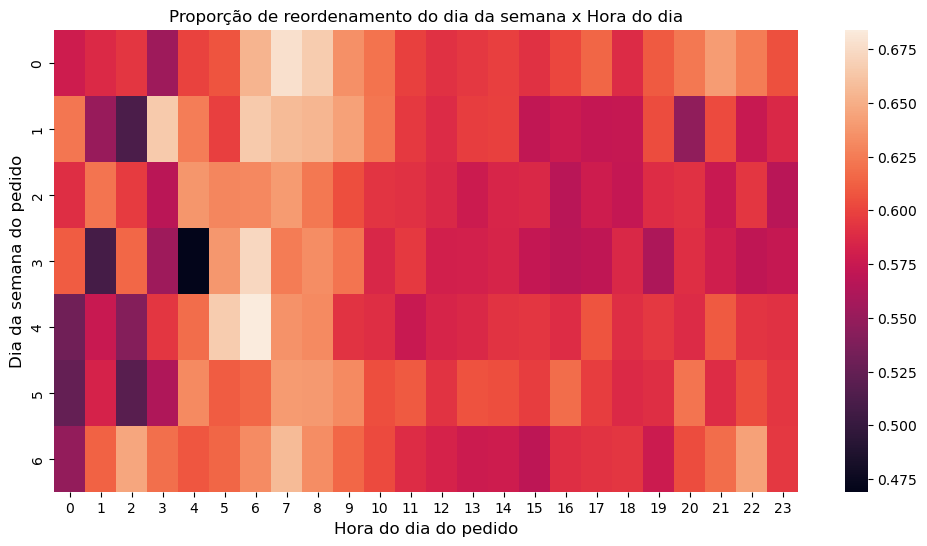

In [69]:
grouped_df = order_products_train.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.ylabel('Dia da semana do pedido', fontsize=12)
plt.xlabel('Hora do dia do pedido', fontsize=12)
plt.title("Proporção de reordenamento do dia da semana x Hora do dia")
plt.show()

* Analisando os gráficos acima, as taxas de novos pedidos são significativamente mais altas durante as primeiras horas da manhã em comparação com a segunda metade do dia.

##### Esses insights oferecem uma compreensão valiosa dos padrões de compra dos usuários na plataforma Instacart, permitindo oportunidades para otimização de estoque, personalização de ofertas e aprimoramento da experiência do cliente.